## 使用SVM 對PM25做預測

透過當天的PM2.5數值與溫度、濕度，來預測隔天的空氣品質好壞<br>
好壞定義:<br>
台灣參考世界衛生組織建議，訂定PM2.5空氣品質標準，24小時平均值為35微克/每立方公尺，所以超過35微克就算不好

## 匯入所需套件

1. numpy - 矩陣處理的套件
2. seaborn - 資料視覺化套件，是 matplotlib 在封裝而成，目的是方便呼叫特殊的圖表
3. pandas - 資料處理套件，在 numpy 基礎上加入許多常用的資料處理方法
4. sklearn - 科學運算套件
    - model_selection train_test_split：方便資料分割的方法
    - svm：svm實現方法
    - metrics：量測運算結果的方法

   

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
%matplotlib inline

## 讀取資料

利用 pandas 一行將 csv 料讀取進來

並呈現前 5 筆資料

In [3]:
data = pd.read_csv("PM25_train.csv",encoding = "utf8")
# data = _data

資料:由許多不同感測器取得的一月份空氣品質資料
![](https://i.imgur.com/NeDwRVt.png)

## data clean
查看資料有無空值及型態

In [4]:
data.isnull().sum()

device_id      0
Date           0
Time           0
PM2.5          0
PM10           0
PM1            0
Temperature    0
Humidity       0
lat            0
lon            0
dtype: int64

刪除lat、lon、PM10、PM1欄位

In [5]:
data = data.drop(['PM10','PM1','lat','lon'],axis=1)
data.head()

,device_id,Date,Time,PM2.5,Temperature,Humidity
0,28C2DDDD415C,2017-01-01,08:03:09,21.0,24.12,83.0
1,28C2DDDD415C,2017-01-01,08:03:09,21.0,24.12,83.0
2,28C2DDDD415C,2017-01-01,08:03:09,21.0,24.12,83.0
3,28C2DDDD415C,2017-01-01,08:09:04,20.0,24.12,82.0
4,28C2DDDD415C,2017-01-01,08:09:04,20.0,24.12,82.0


當天有多筆感測器資料，將所有感測器資料以id與日期為基準做平均

In [6]:
mean_data = data.groupby(['device_id','Date']).mean()
mean_data.head(3)

PM2.5  Temperature   Humidity
device_id    Date                                         
28C2DDDD415C 2017-01-01  17.197279    26.624762  73.476190
             2017-01-02  33.263158    25.061421  81.178947
             2017-01-03  27.547945    24.579315  93.993151

增加quality 欄位，以隔天PM2.5數值是否超過為基準分為兩類

In [15]:
def is_bad(x):
    if x >= 35:
        return 1
    else:
        return 0
mean_data['quality']= mean_data['PM2.5'].apply(is_bad)

'''
上面的 code 可以拆解以下 3 個步驟

1. mean_data['PM2.5'].apply(func)

針對 mean_data 中 PM2.5 的欄位的每個值，apply 一個 function

2. 定義好一個檢查帶進去的參數是否 >= 35 的 function

3. 把 1+2 的結果，在 mean_data 中新增新的欄位 quality 放入

理論上，利用 for 迴圈 + IF 判斷式 一個一個跑，也是有一樣的結果

'''

mean_data['quality'] = mean_data["quality"].shift(-1) # quality 的值上移一格

'''
因為目標是要預測 "明天" 的空氣品質，所以把剛剛計算完的值往前移一天
'''

mean_data.head()

PM2.5  Temperature   Humidity  quality
device_id    Date                                                  
28C2DDDD415C 2017-01-01  17.197279    26.624762  73.476190      0.0
             2017-01-02  33.263158    25.061421  81.178947      0.0
             2017-01-03  27.547945    24.579315  93.993151      0.0
             2017-01-04  17.487310    26.476548  85.685279      1.0
             2017-01-05  53.893401    26.106142  83.796954      1.0

上一步操作中，會將索引(index)變成文字型態(因為把資料 group 過了)

為了方便之後操作，將索引還原回去數字型態

In [9]:
data=mean_data.reset_index(inplace=False)
data.head()

,device_id,Date,PM2.5,Temperature,Humidity,quality
0,28C2DDDD415C,2017-01-01,17.197279,26.624762,73.476190,0.0
1,28C2DDDD415C,2017-01-02,33.263158,25.061421,81.178947,0.0
2,28C2DDDD415C,2017-01-03,27.547945,24.579315,93.993151,0.0
3,28C2DDDD415C,2017-01-04,17.487310,26.476548,85.685279,1.0
4,28C2DDDD415C,2017-01-05,53.893401,26.106142,83.796954,1.0


刪除1/30的資料，因為沒有31號的結果

In [10]:
data= data[data.Date != "2017-01-30"]

In [12]:
data.head(30)

,device_id,Date,PM2.5,Temperature,Humidity,quality
0,28C2DDDD415C,2017-01-01,17.197279,26.624762,73.476190,0.0
1,28C2DDDD415C,2017-01-02,33.263158,25.061421,81.178947,0.0
2,28C2DDDD415C,2017-01-03,27.547945,24.579315,93.993151,0.0
3,28C2DDDD415C,2017-01-04,17.487310,26.476548,85.685279,1.0
4,28C2DDDD415C,2017-01-05,53.893401,26.106142,83.796954,1.0
5,28C2DDDD415C,2017-01-06,55.308989,26.390674,87.320225,1.0
6,28C2DDDD415C,2017-01-07,46.329843,26.400733,90.366492,0.0
7,28C2DDDD415C,2017-01-08,31.641975,23.772346,85.283951,1.0
8,28C2DDDD415C,2017-01-09,42.386935,22.189397,76.391960,1.0
9,28C2DDDD415C,2017-01-10,46.429319,22.862408,70.109948,1.0


確認目標分布均勻

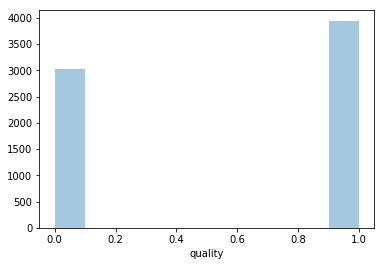

In [13]:
sns.distplot(data['quality'],kde=False)


## 訓練/測試資料分群


以8:2分訓練與測試資料<br>

訓練資料為PM2.5、Temperature、Humidity<br>

目標為預測隔天PM2.5是好是壞

In [16]:

X = data[['PM2.5','Temperature','Humidity']]
Y = data[['quality']]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

## 創建 model
訓練 SVM模型


In [17]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## 測試資料進行預測

In [18]:
pred = svm_model.predict(X_test)

模型準確率

In [19]:
print("accuracy:%.2f"% metrics.accuracy_score(y_test, pred))

accuracy:0.72


統計出混淆矩陣

混淆矩陣可以讓我們知道預測的結果中誤判的情形

套回 pandas 增加資料可讀性

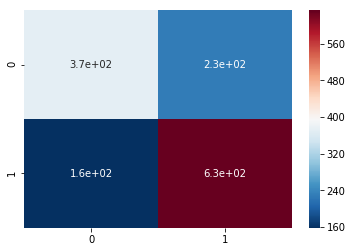

In [20]:
SVM_confusion_matrix = metrics.confusion_matrix(np.asarray(y_test), pred)
cm =pd.DataFrame(SVM_confusion_matrix , index = ['0', '1',], columns = ['0', '1'])
sns.heatmap(cm, annot = True ,cmap="RdBu_r")  

## 選擇不同的特徵做訓練
上面只簡單取PM2.5與溫溼度做訓練，如果再增加其他的特徵可能會讓模型有更好的效果

## 增加經緯度資料訓練

In [21]:
data = pd.read_csv("PM25_train.csv",encoding = "utf8")
mean_data = data.groupby(['device_id','Date']).mean()
mean_data['quality']= mean_data['PM2.5'].apply(lambda x: fun(x))
mean_data['quality'] = mean_data["quality"].shift(-1)
data=mean_data.reset_index(inplace=False)
data= data[data.Date != "2017-01-30"]

X = data[['PM2.5','Temperature','Humidity','lat','lon']]
Y = data[['quality']]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
pred = svm_model.predict(X_test)
print("accuracy:%.2f"% metrics.accuracy_score(y_test, pred))

NameError: name 'fun' is not defined

## 增加PM10、PM1的資訊做訓練

因為感測器不同，有些資訊料沒有PM10或PM1的數值
沒數值的資料直接丟棄

In [ ]:
data = pd.read_csv("PM25_train.csv",encoding = "utf8")
data =data[data["PM10"] > 0] #取有PM10數值的資料
data =data[data["PM1"] > 0] #取有PM1數值的資料
mean_data = data.groupby(['device_id','Date']).mean()
mean_data['quality']= mean_data['PM2.5'].apply(lambda x: fun(x))
mean_data['quality'] = mean_data["quality"].shift(-1)
data=mean_data.reset_index(inplace=False)
data= data[data.Date != "2017-01-30"]

X = data[['PM2.5','Temperature','Humidity','lat','lon','PM10','PM1']]
Y = data[['quality']]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
pred = svm_model.predict(X_test)
print("accuracy:%.2f"% metrics.accuracy_score(y_test, pred))

| 資料     | accuracy | 
| -------- | -------- |
| 只取PM2.5與溫溼度    | 0.72     | 
| 增加經緯度資訊 | 0.74     |
| 增加PM1與PM10資訊     | 0.73     | 